In [1]:
%matplotlib inline
from matplotlib.pyplot import *

In [2]:
import os
import sys
sys.path.append('../config')

In [10]:
from refractor.factory import process_config
from refractor import framework as rf
from refractor.factory import creator, param

In [4]:
from retrieval_config import retrieval_config_definition

In [5]:
data_dir = os.path.realpath('../test/in')
l1b_file = os.path.join(data_dir, "oco2_L1bScND_16094a_170711_B7302r_171102090317-selected_ids.h5")
met_file = os.path.join(data_dir, "oco2_L2MetND_16094a_170711_B8000r_171017214714-selected_ids.h5")

sounding_id = "2017071110541471"

In [6]:
config_def = retrieval_config_definition(l1b_file, met_file, sounding_id)

In [35]:
class WaterInLog(creator.base.Creator):
    met = param.InstanceOf(rf.Meteorology)
    
    def create(self, **kwargs):
        gas_name = "H2O"
        met = self.met()
        pressure = met.pressure_levels
        vmr_profile = met.vmr(gas_name)
        press_obj = rf.PressureSigma(pressure, pressure[-1], False)
        ret_flag = np.ones(vmr_profile.shape, dtype=bool)
        return rf.AbsorberVmrLevelLog(press_obj, vmr_profile, ret_flag, gas_name)

In [36]:
config_def['atmosphere']['absorber']['H2O']['vmr']['creator'] = WaterInLog

In [49]:
class AddWaterCov(creator.value.LoadValuesFromHDF):
    met = param.InstanceOf(rf.Meteorology)
    
    def create(self, **kwargs):
        cov_dict = super().create(**kwargs)
        
        gas_name = "H2O"
        met = self.met()
        vmr_profile = met.vmr(gas_name)
        
        h2o_cov = np.zeros((vmr_profile.shape[0], vmr_profile.shape[0]))
        np.fill_diagonal(h2o_cov, 1.0)
        
        cov_dict['absorber_log_levels/H2O'] = h2o_cov
        
        return cov_dict

In [50]:
config_def['retrieval']['covariance']['values']['creator'] = AddWaterCov

In [52]:
config_inst = process_config(config_def)

----

In [53]:
fm = config_inst.forward_model
atm = config_inst.atmosphere
sv = config_inst.retrieval.state_vector
solver = config_inst.retrieval.solver

In [54]:
def plot_fm(channel_idx):
    low_res_grid = fm.spectral_grid.low_resolution_grid(channel_idx).data
    l1b_grid = config_inst.instrument.pixel_spectral_domain(0).data
    l1b = config_inst.input.l1b
    rad = fm.radiance(channel_idx)
    plot(l1b_grid, l1b.radiance(channel_idx).data)
    plot(low_res_grid, rad.spectral_range.data)
    ylabel("$ mW / sr / m^2 / cm^{-1} $")
    xlabel("Wavenumber (cm^-1)")
    legend(['measured', 'modeled'], loc='best')

In [55]:
for n, v in zip(sv.state_vector_name, sv.state):
    print("%0.10f %s" % (v,n))

0.0003928963 CO2 VMR for Press Lvl 1
0.0003996816 CO2 VMR for Press Lvl 2
0.0004028708 CO2 VMR for Press Lvl 3
0.0004032563 CO2 VMR for Press Lvl 4
0.0004032365 CO2 VMR for Press Lvl 5
0.0004032166 CO2 VMR for Press Lvl 6
0.0004031972 CO2 VMR for Press Lvl 7
0.0004031773 CO2 VMR for Press Lvl 8
0.0004031568 CO2 VMR for Press Lvl 9
0.0004031357 CO2 VMR for Press Lvl 10
0.0004031140 CO2 VMR for Press Lvl 11
0.0004030914 CO2 VMR for Press Lvl 12
0.0004030685 CO2 VMR for Press Lvl 13
0.0004030445 CO2 VMR for Press Lvl 14
0.0004030201 CO2 VMR for Press Lvl 15
0.0004029951 CO2 VMR for Press Lvl 16
0.0004029690 CO2 VMR for Press Lvl 17
0.0004029422 CO2 VMR for Press Lvl 18
0.0004029145 CO2 VMR for Press Lvl 19
0.0004028862 CO2 VMR for Press Lvl 20
-12.4295777306 H2O Log VMR for Press Lvl 1
-12.1649119675 H2O Log VMR for Press Lvl 2
-12.0296920332 H2O Log VMR for Press Lvl 3
-11.9846578163 H2O Log VMR for Press Lvl 4
-11.9389941814 H2O Log VMR for Press Lvl 5
-11.9158941635 H2O Log VMR for Pre

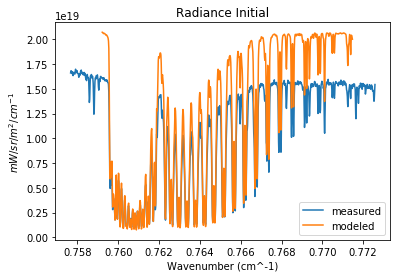

In [56]:
plot_fm(0)
title("Radiance Initial");

In [57]:
%time solver.solve()

CPU times: user 4min 46s, sys: 3min 12s, total: 7min 59s
Wall time: 7min 57s


In [58]:
solver.num_accepted_steps

4

In [59]:
solver.status_str

'SUCCESS'

In [60]:
solver.cost_at_accepted_points

(588948.1064322738,
 9929.587155043775,
 121769.08519348098,
 2069.4378013143532,
 2094.804724117734)

In [61]:
for n, v in zip(sv.state_vector_name, sv.state):
    print("%0.10f %s" % (v,n))

0.0003928983 CO2 VMR for Press Lvl 1
0.0003996885 CO2 VMR for Press Lvl 2
0.0004028537 CO2 VMR for Press Lvl 3
0.0004032214 CO2 VMR for Press Lvl 4
0.0004029814 CO2 VMR for Press Lvl 5
0.0004027798 CO2 VMR for Press Lvl 6
0.0004026734 CO2 VMR for Press Lvl 7
0.0004025714 CO2 VMR for Press Lvl 8
0.0004024448 CO2 VMR for Press Lvl 9
0.0004023178 CO2 VMR for Press Lvl 10
0.0004020524 CO2 VMR for Press Lvl 11
0.0004017700 CO2 VMR for Press Lvl 12
0.0004012816 CO2 VMR for Press Lvl 13
0.0004007398 CO2 VMR for Press Lvl 14
0.0003998888 CO2 VMR for Press Lvl 15
0.0003990155 CO2 VMR for Press Lvl 16
0.0003978634 CO2 VMR for Press Lvl 17
0.0003968046 CO2 VMR for Press Lvl 18
0.0003957444 CO2 VMR for Press Lvl 19
0.0003953720 CO2 VMR for Press Lvl 20
-12.4295777306 H2O Log VMR for Press Lvl 1
-12.1649119675 H2O Log VMR for Press Lvl 2
-12.0296920332 H2O Log VMR for Press Lvl 3
-11.9846578163 H2O Log VMR for Press Lvl 4
-11.9389941796 H2O Log VMR for Press Lvl 5
-11.9158938562 H2O Log VMR for Pre

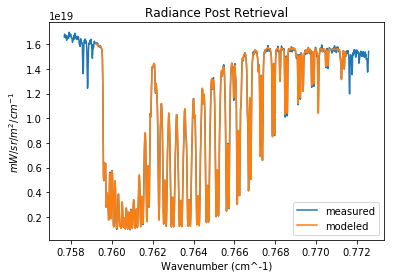

In [62]:
plot_fm(0)
title("Radiance Post Retrieval");